# Head pose regression sample

Based on original fast.ai lesson 2018/3.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina' #for HiDpi display

In [2]:
from colorfuldim import ActivationsHistogram

In [3]:
from fastai.vision import *

# Print current version
from fastai.version import __version__
print('fastai version: ', __version__)

fastai version:  1.0.53.dev0


In [4]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [5]:
# Support data for label function
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

epoch,train_loss,valid_loss,time
0,0.047483,0.006601,00:48
1,0.018018,0.001534,00:51
2,0.008367,0.001155,00:58
3,0.005105,0.000553,00:49
4,0.003778,0.000961,01:02


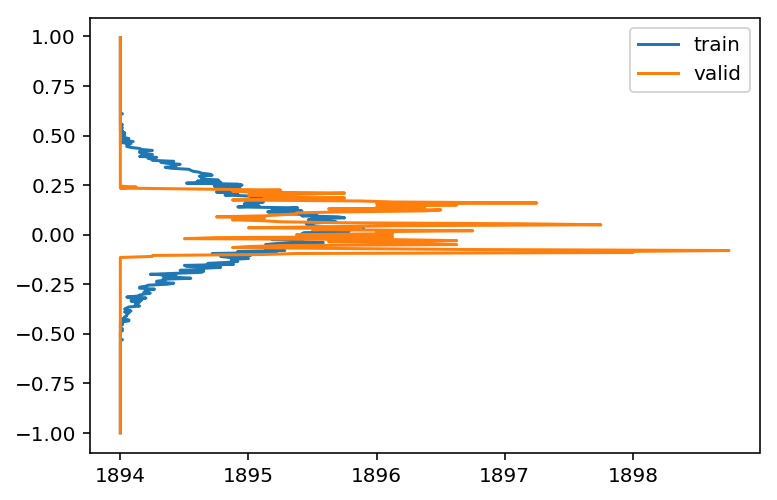

In [7]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13') # Hideout set
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats) # can't change bs
       )

actsh=partial(ActivationsHistogram,hMin=-1,hMax=1,nBins=400,modulesId=[-1],useClasses=True)
learn = cnn_learner(data, models.resnet34, callback_fns=[actsh])
learn.fit_one_cycle(5, slice(2e-2))

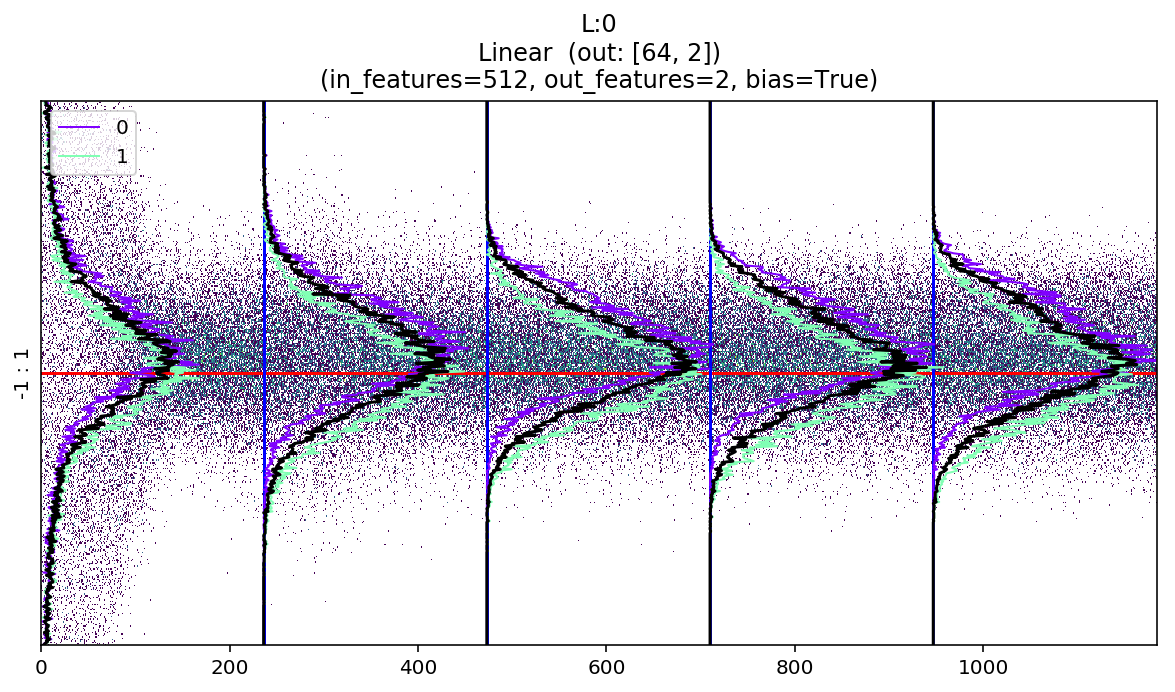

In [18]:
learn.activations_histogram.plotActsHist(cols=3, figsize=(10,5),hScale=250, showLayerInfo=True)

epoch,train_loss,valid_loss,time
0,0.002113,0.000345,00:50
1,0.001232,0.000375,00:48
2,0.001191,0.000330,00:49
3,0.000944,0.000264,00:48
4,0.000951,0.000164,00:49


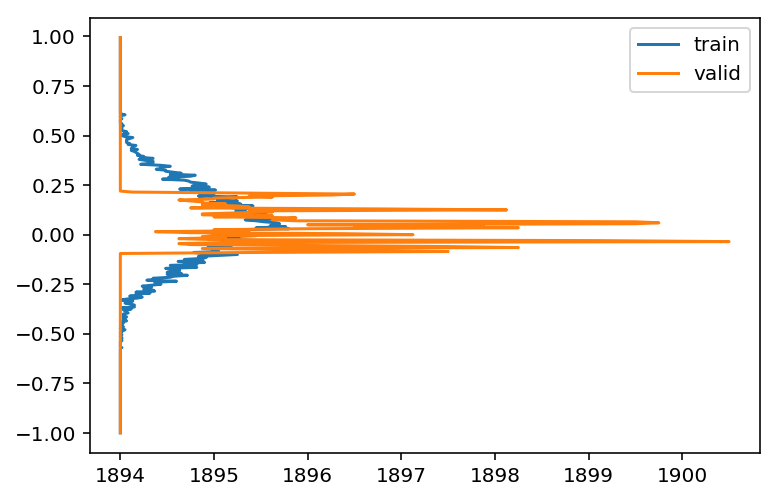

In [20]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3))

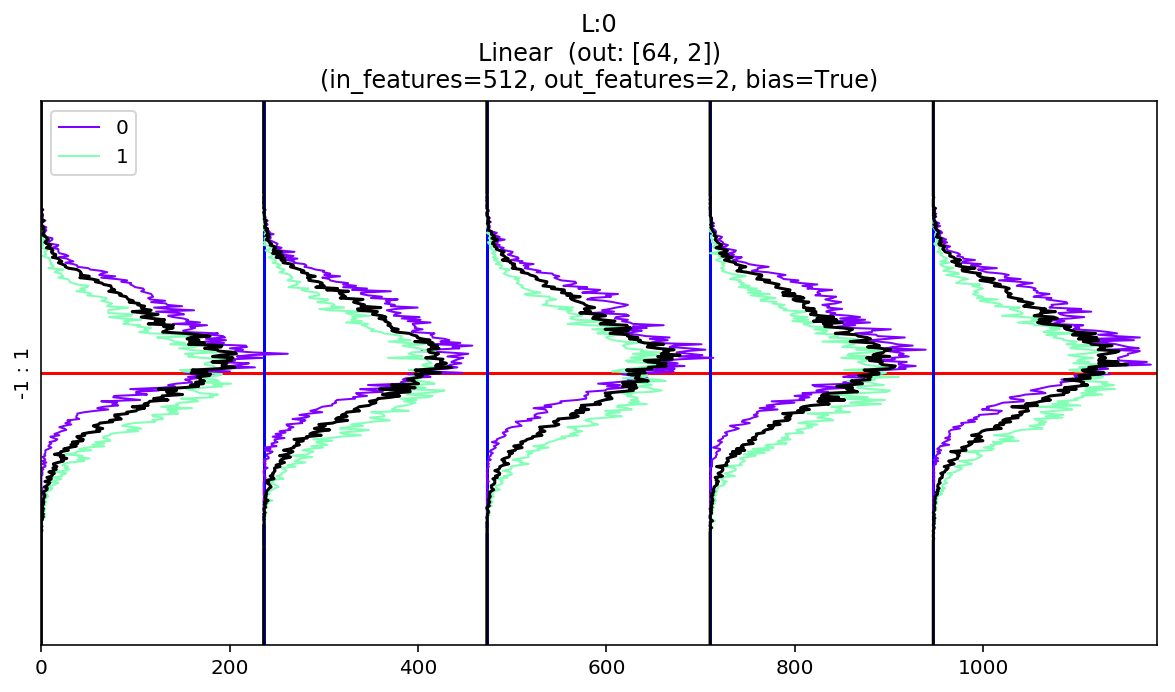

In [22]:
learn.activations_histogram.plotActsHist(cols=3, figsize=(10,5),hScale=250, showLayerInfo=True, showImage=False)